<a href="https://colab.research.google.com/github/zahraDehghanian97/classify_cell_division_phase/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [58]:
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Preprocess data


1. Read "BF_cells_on_grid.csv" (Brighfield features) and "SSC.csv" (Darkfield features) as pandas Dataframe

In [27]:
url_bf = "https://raw.githubusercontent.com/zahraDehghanian97/classify_cell_division_phase/master/BF_cells_on_grid.csv"
bf_df = pd.read_csv(url_bf,on_bad_lines='skip')
url_df = "https://raw.githubusercontent.com/zahraDehghanian97/classify_cell_division_phase/master/SSC.csv"
df_df = pd.read_csv(url_df,on_bad_lines='skip')

In [29]:
bf_df.head()

,ImageNumber,ObjectNumber,AreaShape_Area,AreaShape_Center_X,AreaShape_Center_Y,AreaShape_Compactness,AreaShape_Eccentricity,AreaShape_EulerNumber,AreaShape_Extent,AreaShape_FormFactor,...,Texture_SumEntropy_BF_image_3_45,Texture_SumEntropy_BF_image_3_90,Texture_SumVariance_BF_image_3_0,Texture_SumVariance_BF_image_3_135,Texture_SumVariance_BF_image_3_45,Texture_SumVariance_BF_image_3_90,Texture_Variance_BF_image_3_0,Texture_Variance_BF_image_3_135,Texture_Variance_BF_image_3_45,Texture_Variance_BF_image_3_90
0,1,1,1148.0,27.0,28.0,1.001694,0.318706,1.0,0.795565,0.914040,...,2.440405,2.420252,11.998006,10.126384,10.280260,11.797080,3.677694,4.195472,3.802830,3.956518
1,1,2,824.0,25.0,84.0,1.027350,0.556030,1.0,0.715278,0.825853,...,2.172302,2.254057,5.339414,5.786332,4.879558,5.716457,2.244609,2.615223,2.255126,2.470824
2,1,3,1127.0,28.0,138.0,1.005466,0.422347,1.0,0.802707,0.909265,...,2.291793,2.316845,8.077251,7.391653,7.160918,9.038275,2.770572,3.173958,2.853978,2.997233
3,1,4,1006.0,28.0,189.0,1.030017,0.603568,1.0,0.806090,0.873266,...,1.983694,2.011501,4.003409,3.714048,3.692521,4.520115,1.572012,1.782776,1.609564,1.669106
4,1,5,1105.0,28.0,245.0,1.019525,0.559239,1.0,0.770035,0.888068,...,2.143550,2.169470,5.858220,5.238164,5.182886,6.363456,1.959733,2.253920,2.000566,2.088864



2. Based on the folders of each image determine the ground truth label for each image (feature vector)
    + Use only 5 different classes. G1/G2/S as class 0, Prophase as class 1, Metaphase as class 2, Anaphase as class 3 and Telophase as class 4

In [34]:
dict_label = {1: 3, 2: 0, 3:0,4:2 , 5:1 , 6:0 , 7: 4 }
ground_truth = []
for index in range(len(bf_df["ImageNumber"])):
  ground_truth.append(dict_label[int(bf_df["ImageNumber"][index])])
ground_truth[:10]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]



3. Only some of the columns are useful for classification. Only keep the useful ones.

In [36]:
brf_exclude_cols = [0,1,3,4,7,17,19] + list(range(70,77))       # Exclude these columns from brightfield features
daf_exclude_cols = list(range(0,50)) + list(range(70,77))       # Exclude these columns from darkfield features
bf_df.drop(bf_df.columns[brf_exclude_cols],axis=1,inplace=True)
df_df.drop(df_df.columns[daf_exclude_cols],axis=1,inplace=True)
bf_df.head()

,AreaShape_Area,AreaShape_Compactness,AreaShape_Eccentricity,AreaShape_Extent,AreaShape_FormFactor,AreaShape_MajorAxisLength,AreaShape_MaxFeretDiameter,AreaShape_MaximumRadius,AreaShape_MeanRadius,AreaShape_MedianRadius,...,Texture_SumEntropy_BF_image_3_45,Texture_SumEntropy_BF_image_3_90,Texture_SumVariance_BF_image_3_0,Texture_SumVariance_BF_image_3_135,Texture_SumVariance_BF_image_3_45,Texture_SumVariance_BF_image_3_90,Texture_Variance_BF_image_3_0,Texture_Variance_BF_image_3_135,Texture_Variance_BF_image_3_45,Texture_Variance_BF_image_3_90
0,1148.0,1.001694,0.318706,0.795565,0.914040,39.273869,39.051248,18.681542,6.623417,5.830952,...,2.440405,2.420252,11.998006,10.126384,10.280260,11.797080,3.677694,4.195472,3.802830,3.956518
1,824.0,1.027350,0.556030,0.715278,0.825853,35.719758,35.355339,14.317821,5.423662,5.000000,...,2.172302,2.254057,5.339414,5.786332,4.879558,5.716457,2.244609,2.615223,2.255126,2.470824
2,1127.0,1.005466,0.422347,0.802707,0.909265,39.800233,39.293765,18.000000,6.545845,5.830952,...,2.291793,2.316845,8.077251,7.391653,7.160918,9.038275,2.770572,3.173958,2.853978,2.997233
3,1006.0,1.030017,0.603568,0.806090,0.873266,40.168129,38.832976,15.524175,6.037000,5.385165,...,1.983694,2.011501,4.003409,3.714048,3.692521,4.520115,1.572012,1.782776,1.609564,1.669106
4,1105.0,1.019525,0.559239,0.770035,0.888068,41.234333,40.199502,16.492423,6.366687,5.656854,...,2.143550,2.169470,5.858220,5.238164,5.182886,6.363456,1.959733,2.253920,2.000566,2.088864


In [37]:
print((bf_df.shape))
print((df_df.shape))

(1575, 128)
(1575, 85)



4. Concat brightfield and darkfield features and append the ground truth as the last column.

In [57]:
feature_df = bf_df.join(df_df, lsuffix="b")
label_df = pd.DataFrame(ground_truth,columns=["label"])
df = feature_df.join(label_df)



5. After merging, delete all rows that contain any "nan" value.


In [64]:
df=df.dropna() 

6. To make sure that you didn't make any mistake, check that the final dataframe must have 1007 rows and 214 columns. 

In [65]:
df.reset_index(drop= True,inplace=True)
print(df.shape)
df.info()

(1008, 214)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Columns: 214 entries, AreaShape_Area to label
dtypes: float64(213), int64(1)
memory usage: 1.6 MB


# Fit a classifier



1. Split the dataset into train/test.

In [66]:
X = df.drop('label',axis=1)
y = df[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)


2. Fit a classifier on the train data.
    + No need to implement any complex classifier. You can use the available classifiers in sklearn such as decision trees.

In [67]:
from sklearn.tree import DecisionTreeClassifier
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=8, min_samples_leaf=5)   
clf_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=42)


3. Evaluate the model on the test set.

In [68]:
y_predict = clf_model.predict(X_test)


4. Report accuracy and plot the confusion matrix.

In [69]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(y_test,y_predict)

0.7326732673267327

In [70]:
confusion_matrix(y_test,y_predict)

array([[180,  21,   0,   0,   0],
       [ 33,  30,   0,   0,   0],
       [ 10,  10,   2,   3,   1],
       [  1,   1,   0,   4,   0],
       [  1,   0,   0,   0,   6]])

show tree

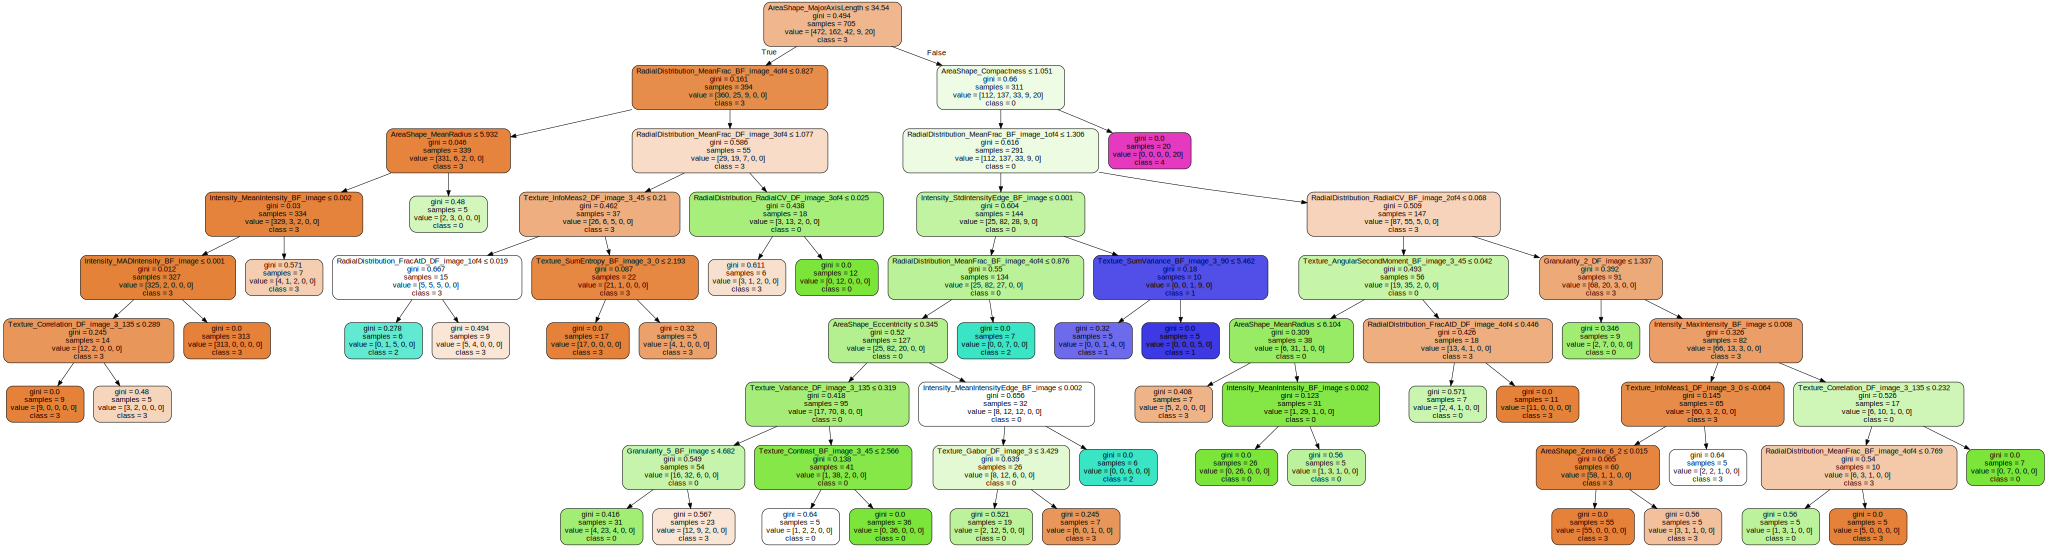

In [75]:
target = list(df['label'].unique())
t = []
for i in target: t.append(str(i))
target = t
feature_names = list(X.columns)
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(clf_model,
                                out_file=None, 
                      feature_names=feature_names,  
                      class_names=target,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph